# Predicting Hospital Readmission with Discharge Summaries

# Model definition¶

**Predict which patients are at risk for 30-day unplanned readmission utilizing free-text hospital discharge summaries.**

Medical Information Mart for Intensive Care III(MIMIC-III) is a free hospital database. It harbors de-identified information from over 40,000 patients who were admitted to Beth Israel Deaconess Medical Center in Boston, Massachusetts from 2001 to 2012.

For this project we will use two tables from this database:

**ADMISSIONS** - a table containing patients information including the admission and discharge dates for each admission

**NOTEEVENTS** - a table containing all notes for each hospitalization
Both these tables share Hospital admission IDs (HADM_ID)

Due to the restricted access, the github version of this code will show minimal individual patient data.

# Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
from datetime import datetime 


# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from matplotlib.ticker import StrMethodFormatter

In [2]:
df_raw = pd.read_csv('NOTEEVENTS.csv.gz', compression='gzip', low_memory=False)
df_raw_b = df_raw.copy()
print(df_raw.shape)
df_raw_b.sample(1)

(2083180, 11)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
2031781,2031035,26022,101015.0,2162-01-26,2162-01-26 13:21:00,2162-01-26 13:22:00,Nursing/other,Report,15938.0,NaN,"[** 63**] Physical Exam\nPE: pink, AFOF, breat..."


# Data pre-processing

## ADMISSIONS

In [3]:
# Load data and peak into the data
admissions=pd.read_csv('ADMISSIONS.csv')
admissions.sample(5)
print(admissions.columns.tolist())

['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA']


**There is no readmission time column is not part of the dataset. However this can be calculated from** 
* 'ADMITTIME', 
* 'DISCHTIME'

**For this project we are interested in predicting readmission based on the discharge summaries. Hence we will not consider any other information pertaining to the patient. These include:**
* 'ADMISSION_LOCATION' 
* 'DISCHARGE_LOCATION' 
* 'INSURANCE'
* 'LANGUAGE' 
* 'RELIGION' 
* 'MARITAL_STATUS' 
* 'ETHNICITY'
* 'EDREGTIME' 
* 'EDOUTTIME' 
* 'DIAGNOSIS' 
* 'HOSPITAL_EXPIRE_FLAG' 
* 'HAS_CHARTEVENTS_DATA'

**The columns we will start working with are:**
**Columns with IDs**
* 'ROW_ID'     - Numeric & index. We will drop after data wrangling
* 'SUBJECT_ID' - Important 
* 'HADM_ID'    - Important 
**Time information**
* 'ADMITTIME'  - Important 
* 'DISCHTIME'  - Important 
* 'DEATHTIME'  - Important
****
* 'ADMISSION_TYPE' - Explore this column 

In [4]:
# Subset just the dataframe to work only with the important columns
admissions = admissions[['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME',
                         'DEATHTIME','DISCHTIME', 'ADMISSION_TYPE']]

### ADMISSION_TYPE

**Let's explore the feature admission_type**

(-1500, 50000)

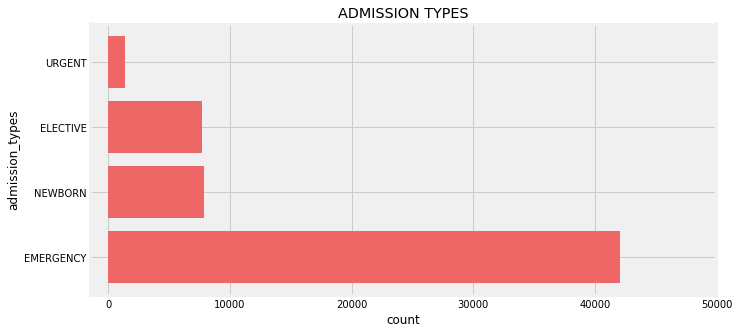

In [5]:
admission_types = admissions['ADMISSION_TYPE'].value_counts().to_dict()
names = list(admission_types.keys())
values = list(admission_types.values())

fig, ax = plt.subplots(figsize=(10,5))
ax.barh(names, values, color='#EE6666')
ax.set(title='ADMISSION TYPES', ylabel='admission_types', xlabel='count')
ax.set_xlim(-1500, 50000)

**Since we are interested in predicting unplanned readmission. We will not consider 
information about patients who opted for hospital admission**

### Select patients who came to the 'emergency 'or 'urgent care'

In [6]:
# Extract index values 
emerg_urg_idx = admissions[(admissions['ADMISSION_TYPE'] == 'EMERGENCY') | 
                              (admissions['ADMISSION_TYPE'] == 'URGENT')].index.values
# Subset the dataframe
admissions = admissions.loc[emerg_urg_idx, :]

### Remove the information of dead patients

In [7]:
# Select patient with no deathtime given assuming they are alive
admissions = admissions[admissions['DEATHTIME'].isnull()]

#Drop the deathtime column since it is only a null column
admissions.drop(['DEATHTIME'], axis=1, inplace=True)
admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,EMERGENCY
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,EMERGENCY
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,EMERGENCY
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,EMERGENCY
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,EMERGENCY


### Convert date and time columns to datetime objects and  create new features to compute days until the next admission

In [8]:
admissions[['ADMITTIME', 'DISCHTIME']] = admissions[['ADMITTIME', 'DISCHTIME']].apply(
    pd.to_datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce')

# sort by subject_ID and admission date
admissions = admissions.sort_values(['SUBJECT_ID','ADMITTIME']).reset_index(drop=True)

Add the next admission date and type columns for each subject using groupby. Groupby is necessary otherwise the dates will be from different users

In [9]:
# Next 'ADMITTIME'
admissions['NEXT_ADMITTIME'] = admissions.groupby('SUBJECT_ID')[
    'ADMITTIME'].shift(-1)
# Next 'ADMITTYPE'
admissions['NEXT_ADMISSION_TYPE'] = admissions.groupby(
    'SUBJECT_ID')['ADMISSION_TYPE'].shift(-1)

In [10]:
rows = admissions[admissions['NEXT_ADMISSION_TYPE']
                    == 'ELECTIVE'].index.values
admissions.loc[rows, 'NEXT_ADMISSION_TYPE'] = np.NaN
admissions.loc[rows, 'NEXT_ADMITTIME'] = pd.NaT

In [11]:
# sort by subject_ID and admission date
# it is safer to sort right before the fill incase something changed the order above
admissions = admissions.sort_values(['SUBJECT_ID', 'ADMITTIME'])

# back fill (this will take a little while)
admissions[['NEXT_ADMITTIME', 'NEXT_ADMISSION_TYPE']] = admissions.groupby(
    ['SUBJECT_ID'])[['NEXT_ADMITTIME', 'NEXT_ADMISSION_TYPE']].fillna(method='bfill')

### Calculate days until next admission¶

In [12]:
# calculate the number of days between discharge and next admission
admissions['DAYS_NEXT_ADMIT'] = (
    admissions['NEXT_ADMITTIME'] - admissions.DISCHTIME).dt.total_seconds()/(24*60*60)

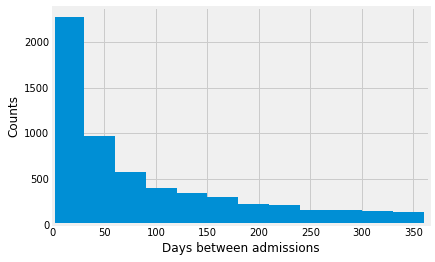

In [13]:
plt.hist(admissions.loc[~admissions.DAYS_NEXT_ADMIT.isnull(), 'DAYS_NEXT_ADMIT'], bins=range(0, 365, 30))
plt.xlim([0, 365])
plt.xlabel('Days between admissions')
plt.ylabel('Counts')
plt.show()

Since not all the columns are important for the classification we will subset the dataframe

## NOTES

In [14]:
# Load the csv file
notes_raw=pd.read_csv('NOTEEVENTS.csv.gz', compression='gzip', low_memory=False, parse_dates=True)
notes=notes_raw.copy()
print(notes.columns.tolist())

['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME', 'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT']


**We are interested in only few columns particularly the 'TEXT','SUBJECT_ID' and 'HADM_ID' columns to combine the dataframe with the admission dataframe. Another column that we are interested in is the 'CATEGORY' column. 

In [15]:
notes['SUBJECT_ID'].isin(admissions['SUBJECT_ID']).astype('int64').sum()

1371881

{'Nursing/other': 822497, 'Radiology': 522279, 'Nursing': 223556, 'ECG': 209051, 'Physician ': 141624, 'Discharge summary': 59652, 'Echo': 45794, 'Respiratory ': 31739, 'Nutrition': 9418, 'General': 8301, 'Rehab Services': 5431, 'Social Work': 2670, 'Case Management ': 967, 'Pharmacy': 103, 'Consult': 98}


[Text(0, 0.5, 'categories'),
 Text(0.5, 0, 'count'),
 Text(0.5, 1.0, 'Distribution of Notes Categories')]

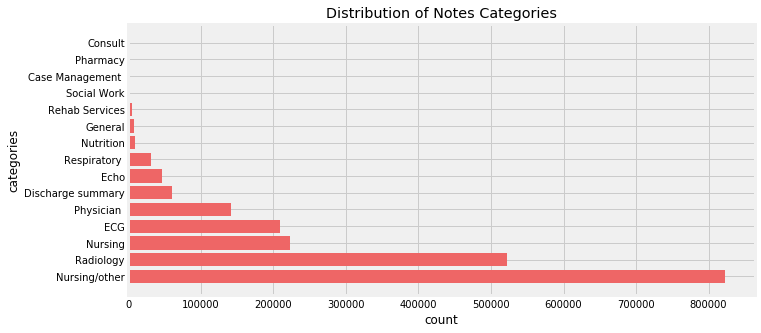

In [16]:
notes_categories = notes['CATEGORY'].value_counts().to_dict()
print(notes_categories)

# Plot a count plot
categories = list(notes_categories.keys())
count = list(notes_categories.values())

figure, ax = plt.subplots(figsize=(10, 5))
ax.barh(categories, count, color='#EE6666')
ax.set(title = 'Distribution of Notes Categories', xlabel='count' , ylabel='categories')

**We are only interested in the discharge summaries and not other notes. Hence we will select only those observations with discharge summaries.**

### Filter the data for observations with discharge summaries

In [17]:
notes_subset = notes[notes['CATEGORY']== 'Discharge summary']
print(notes_subset.head())

   ROW_ID  SUBJECT_ID   HADM_ID   CHARTDATE CHARTTIME STORETIME  \
0     174       22532  167853.0  2151-08-04       NaN       NaN   
1     175       13702  107527.0  2118-06-14       NaN       NaN   
2     176       13702  167118.0  2119-05-25       NaN       NaN   
3     177       13702  196489.0  2124-08-18       NaN       NaN   
4     178       26880  135453.0  2162-03-25       NaN       NaN   

            CATEGORY DESCRIPTION  CGID  ISERROR  \
0  Discharge summary      Report   NaN      NaN   
1  Discharge summary      Report   NaN      NaN   
2  Discharge summary      Report   NaN      NaN   
3  Discharge summary      Report   NaN      NaN   
4  Discharge summary      Report   NaN      NaN   

                                                TEXT  
0  Admission Date:  [**2151-7-16**]       Dischar...  
1  Admission Date:  [**2118-6-2**]       Discharg...  
2  Admission Date:  [**2119-5-4**]              D...  
3  Admission Date:  [**2124-7-21**]              ...  
4  Admission Da

[Text(0, 0.5, 'Normed Frequency'),
 Text(0.5, 0, 'Number of Notes'),
 Text(0.5, 1.0, 'Distribution of number of notes per patient')]

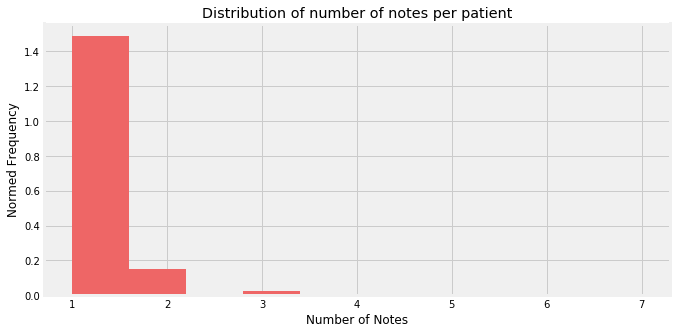

In [18]:
# plot the distribution of number of notes per patient
num_notes_patients = notes_subset.groupby(['SUBJECT_ID','HADM_ID'])['TEXT'].count()

figure, ax = plt.subplots(figsize=(10,5))
ax.hist(num_notes_patients, bins=10, density = True, color='#EE6666')
ax.set(title='Distribution of number of notes per patient', xlabel= 'Number of Notes', ylabel = "Normed Frequency")

**While most patients have only one discharge summary some have more than one. We can either combine all the notes of a patient and use them or only consider the last discharge summary. We will use only the last discharge summary for this model.**

In [19]:
notes_subset = notes_subset.groupby(['SUBJECT_ID','HADM_ID']).nth(-1).reset_index()

[Text(0, 0.5, 'Normed Frequency'),
 Text(0.5, 0, 'Number of Notes'),
 Text(0.5, 1.0, 'Distribution of number of notes per patient')]

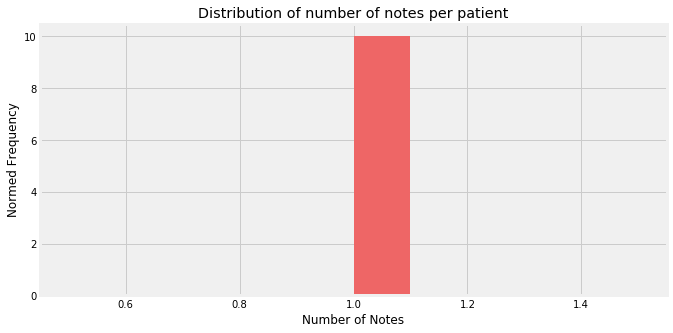

In [20]:
num_notes_patients = notes_subset.groupby(['SUBJECT_ID','HADM_ID'])['TEXT'].count()

figure, ax = plt.subplots(figsize=(10,5))
ax.hist(num_notes_patients, bins=10, density = True, color='#EE6666')
ax.set(title='Distribution of number of notes per patient', xlabel= 'Number of Notes', ylabel = "Normed Frequency")

# Merge Dataframes

In [21]:
merged_df = pd.merge(admissions, notes_subset, on=['SUBJECT_ID','HADM_ID'], how='left')

merged_df.shape

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37812 entries, 0 to 37811
Data columns (total 18 columns):
ROW_ID_x               37812 non-null int64
SUBJECT_ID             37812 non-null int64
HADM_ID                37812 non-null int64
ADMITTIME              37812 non-null datetime64[ns]
DISCHTIME              37812 non-null datetime64[ns]
ADMISSION_TYPE         37812 non-null object
NEXT_ADMITTIME         8521 non-null datetime64[ns]
NEXT_ADMISSION_TYPE    8521 non-null object
DAYS_NEXT_ADMIT        8521 non-null float64
CATEGORY               36732 non-null object
CGID                   0 non-null float64
CHARTDATE              36732 non-null object
CHARTTIME              0 non-null object
DESCRIPTION            36732 non-null object
ISERROR                0 non-null float64
ROW_ID_y               36732 non-null float64
STORETIME              0 non-null object
TEXT                   36732 non-null object
dtypes: datetime64[ns](3), float64(4), int64(3), object(8)
memory usage: 5.

In [22]:
merged_df['TEXT'].isnull().sum()

1080

In [23]:
merged_df.dropna(subset=['TEXT'], inplace=True)

In [24]:
def remove_special_text(text):
    import string
    punc_list=string.punctuation + '0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, ""))
    text = text.lower().translate(t)
    text = text.replace('\n', " ")
    text = text.replace('\r', ' ')
    text = text.replace("(<br/>)", " ")
    text = text.replace('(<a).*(>).*(</a>)',' ')
    text = text.replace('(&amp)', ' ')
    text = text.replace('(&gt)', ' ')
    text = text.replace('(&lt)', ' ')
    text = text.replace('(\xa0)', ' ')
    return text

In [25]:
merged_df['TEXT_CLEAN'] = [remove_special_text(str(i)) for i in merged_df['TEXT']]

In [26]:
merged_df['TEXT'][0]

"Admission Date:  [**2101-10-20**]     Discharge Date:  [**2101-10-31**]\n\nDate of Birth:   [**2025-4-11**]     Sex:  M\n\nService:  Medicine\n\nCHIEF COMPLAINT:  Admitted from rehabilitation for\nhypotension (systolic blood pressure to the 70s) and\ndecreased urine output.\n\nHISTORY OF PRESENT ILLNESS:  The patient is a 76-year-old\nmale who had been hospitalized at the [**Hospital1 190**] from [**10-11**] through [**10-19**] of [**2101**]\nafter undergoing a left femoral-AT bypass graft and was\nsubsequently discharged to a rehabilitation facility.\n\nOn [**2101-10-20**], he presented again to the [**Hospital1 346**] after being found to have a systolic\nblood pressure in the 70s and no urine output for 17 hours.\nA Foley catheter placed at the rehabilitation facility\nyielded 100 cc of murky/brown urine.  There may also have\nbeen purulent discharge at the penile meatus at this time.\n\nOn presentation to the Emergency Department, the patient was\nwithout subjective complaints.  I

In [27]:
merged_df['TEXT_CLEAN'][0]

'admission date       discharge date    date of birth        sex  m  service  medicine  chief complaint  admitted from rehabilitation for hypotension systolic blood pressure to the s and decreased urine output  history of present illness  the patient is a yearold male who had been hospitalized at the hospital  from  through  of  after undergoing a left femoralat bypass graft and was subsequently discharged to a rehabilitation facility  on  he presented again to the hospital  after being found to have a systolic blood pressure in the s and no urine output for  hours a foley catheter placed at the rehabilitation facility yielded  cc of murkybrown urine  there may also have been purulent discharge at the penile meatus at this time  on presentation to the emergency department the patient was without subjective complaints  in the emergency department he was found to have systolic blood pressure of   he was given  liters of intravenous fluids and transiently started on dopamine for a systoli

## Label the observations

In [28]:
merged_df['Label'] = [1 if entry <30 else 0 for entry in merged_df['DAYS_NEXT_ADMIT']]

In [29]:
print(merged_df.columns.tolist())

['ROW_ID_x', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE', 'NEXT_ADMITTIME', 'NEXT_ADMISSION_TYPE', 'DAYS_NEXT_ADMIT', 'CATEGORY', 'CGID', 'CHARTDATE', 'CHARTTIME', 'DESCRIPTION', 'ISERROR', 'ROW_ID_y', 'STORETIME', 'TEXT', 'TEXT_CLEAN', 'Label']


In [30]:
merged_df.drop(['ROW_ID_x',
                'SUBJECT_ID',
                'HADM_ID',
                'ADMITTIME',
                'DISCHTIME',
                'ADMISSION_TYPE',
                'NEXT_ADMITTIME',
                'NEXT_ADMISSION_TYPE',
                'DAYS_NEXT_ADMIT',
                'CATEGORY',
                'CGID',
                'CHARTDATE',
                'CHARTTIME',
                'DESCRIPTION',
                'ISERROR',
                'ROW_ID_y',
                'STORETIME',
                'TEXT'],axis=1, inplace=True)

In [31]:
import feather
feather.write_dataframe(merged_df,'cleaned.feather')

In [32]:
merged_df = feather.read_dataframe('cleaned.feather')

In [33]:
merged_df.head()

,TEXT_CLEAN,Label
0,admission date discharge date date of...,0
1,admission date discharge date date of...,0
2,admission date discharge date ...,0
3,name known lastname known firstname c ...,0
4,admission date discharge date ...,0


## Compute Prevalance

In [34]:
print('The percent of observations belonging to class 0 are {}'.format(
    100 * len(merged_df[merged_df['Label'] == 0])/merged_df.shape[0]))
print('The percent of observations belonging to class 1 are {}'.format(
    100 * len(merged_df[merged_df['Label'] == 1])/merged_df.shape[0]))

The percent of observations belonging to class 0 are 93.93444408145486
The percent of observations belonging to class 1 are 6.0655559185451375


In [35]:
## Under Sample the data

In [36]:
# Class 1
class_1_subset = merged_df[merged_df['Label']==1]

In [37]:
# Class 0
class_0 = merged_df[merged_df['Label'] == 0]
class_0_subset = class_0.sample(len(class_1_subset))

In [38]:
class_0_subset.shape, class_1_subset.shape

((2228, 2), (2228, 2))

In [39]:
# Concatenate the dataframes
small_df = pd.concat([class_0_subset, class_1_subset], ignore_index=True)
#small_df
assert small_df.shape[0] == class_0_subset.shape[0] + class_1_subset.shape[0]

In [40]:
small_df.columns

Index(['TEXT_CLEAN', 'Label'], dtype='object')

In [41]:
import pickle
small_df.to_pickle('small_df.pickle')

# Acknowledgements
I was inspired by the wonderful work of Andrew Long, Data Scientist at Fresenius Medical Care North America. He wrote two excellent blogs in Towards Data Science on this project.